In [3]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import itertools

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run


In [4]:
data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:10, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L2_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights

##########################################
runs = 2
m1 = [1e-4, 1e-3, 1e-2]
m2 = [0.9, 0.7, 0.5]
HPs = itertools.product(m1, m2)

experiments_csv = path_exps / Path("LBFGS_grid_search.csv")
# remove HP combinations already explored
if experiments_csv.exists():
    df = pd.read_csv(experiments_csv)
    HPs_new = []
    for m1,m2 in HPs:
        if ((df['m1'] == m1) & (df['m2'] == m2)).any():
            continue
        else:
            HPs_new.append((m1,m2))
    HPs = HPs_new

for m1, m2 in HPs:
    print(f'Testing m1: {m1}, m2: {m2}', end='')
    solver = LBFGS(eps=1e-4, max_feval=5e4, M=10,m1=m1,m2=m2)
    results = multi_run(solver, f, n=runs)

    log_columns = ["m1", "m2", "f_evals_m", "f_evals_std", "n_failures", "runs"]
    log_data = [m1, m2, results[2], results[3], results[6], runs]
    df = pd.DataFrame([log_data], columns=log_columns)

    if experiments_csv.exists():
        df.to_csv(experiments_csv, mode="a", header=False,index=False)
    else:
        df.to_csv(experiments_csv,index=False)
    print('\t Finished')


Testing m1: 0.0001, m2: 0.5/home/felusiani/Projects/CM/ComputationalMathematics/testing/multiple_runs.py:83: RuntimeWarning: Mean of empty slice.
  final_fv.mean(),
/home/felusiani/Projects/CM/env/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/felusiani/Projects/CM/env/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/felusiani/Projects/CM/env/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/felusiani/Projects/CM/env/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/felusiani/Projects/CM/ComputationalMathematics/testing/multiple_runs.py:85: RuntimeWarni

In [46]:
df = pd.read_csv(experiments_csv)
df.sort_values(by=['f_evals_m'])

,m1,m2,f_evals_m,f_evals_std,n_failures,runs
3,0.0010,0.9,827.5,322.5,0,2
6,0.0100,0.9,913.5,290.5,0,2
1,0.0001,0.7,1014.0,308.0,0,2
8,0.0100,0.5,1025.0,333.0,0,2
0,0.0001,0.9,1061.0,287.0,0,2
4,0.0010,0.7,1265.5,335.5,0,2
5,0.0010,0.5,1332.0,353.0,0,2
7,0.0100,0.7,1415.5,467.5,0,2
2,0.0001,0.5,NaN,NaN,2,2


Text(33.0, 0.5, 'm1')

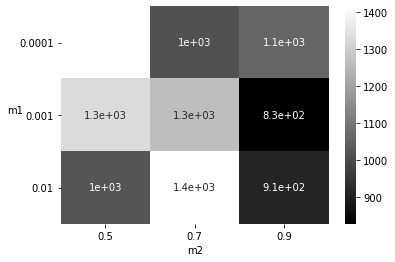

In [52]:
import seaborn as sns
df = pd.read_csv(experiments_csv)
df = df.sort_values(by=['m1','m2'])
m1_vals = df['m1'].unique()
m2_vals = df['m2'].unique()
array = df['f_evals_m'].to_numpy()
matrix = array.reshape((len(m1_vals), len(m2_vals)))

ax = sns.heatmap(matrix,cmap='gray', annot=True,
xticklabels=m2_vals, yticklabels=m1_vals)
plt.yticks(rotation=0)
ax.set_xlabel('m2')
ax.set_ylabel('m1',rotation=0)